Quick Kernel showing two bar graphs side by side, a way to check quickly for missing data, a little feature engineering and some Pandas commands for selecting and filtering data. Then it shows several models being made and evaluated using cross validation. at the end I try some models without using cross validation and check their results.

In [1]:
#graphs and utilities
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#data pre-processing and model evaluation
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

#models
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

def plotMissing(df):
    #will error out if there is no missing data, just for quick use
    sns.set_style("whitegrid")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True,ascending=False)
    missing.plot.bar()

df_full = pd.read_csv('../input/Pokemon.csv')
df_full.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


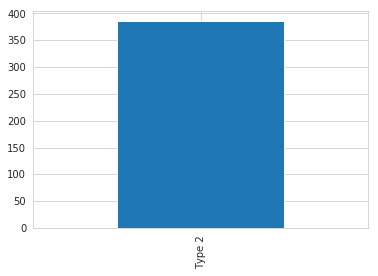

In [2]:
plotMissing(df_full)

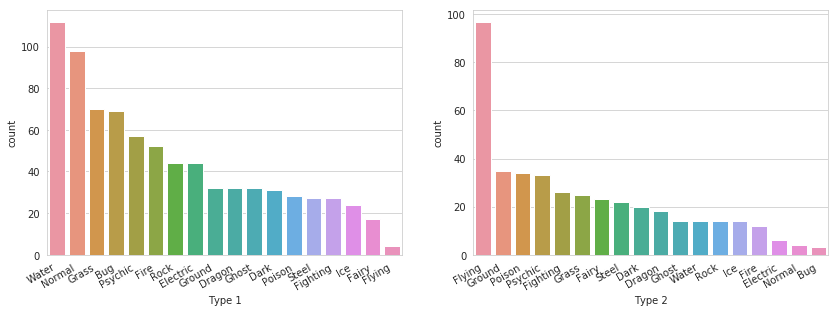

In [3]:
battle_stats = ['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']

#make a column with both types combined to make their full typing
df_full['FullType'] = df_full['Type 1'] + df_full['Type 2']
#if the pokemon only has one type, it needs fixing since nan + string = nan
df_full['FullType'].fillna(df_full['Type 1'],inplace=True)

def makeTarget(df):
    local_df = df_full.iloc[df]
    if local_df['Type 1'] == 'Electric' or local_df['Type 2'] == 'Electric':
        return 1
    return 0

#make a target which tells us if the pokemon is Electric type or not (1 = electric, 0 = not electric)
df_full['Target'] = [makeTarget(x) for x in df_full.index]

#make a column with all the battle stats added together (included on the data but just for knowledge)
#df_full['TotalStat'] = df_full[battle_stats].sum(axis=1)

#bar plot the most common first type (overlaps into one single plot)
#df_types = df_full['Type 1'].value_counts()
#df_types.plot.bar()
#df_types2 = df_full['Type 2'].value_counts()
#df_types.plot.bar()

sns.set_style("whitegrid")
fig, ax =plt.subplots(1,2,figsize=(14,5))
sns.countplot(df_full['Type 1'].sort_values(), ax=ax[0],order = df_full['Type 1'].value_counts().index)
sns.countplot(df_full['Type 2'].sort_values(), ax=ax[1], order = df_full['Type 2'].value_counts().index)
fig.autofmt_xdate()
fig.show()

Pokemon Type frequencies graphs

In [4]:
#make a DF with the highest single stats
df_top_stats = pd.DataFrame(columns=df_full.columns)

for idx,battle_stat in enumerate(battle_stats):
    top_stat = df_full.nlargest(1,battle_stat).sort_values(battle_stat,ascending=False)
    df_top_stats = pd.concat([df_top_stats, top_stat], axis=0)
    
df_top_stats.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,FullType,Target
261,242,Blissey,Normal,NaN,540,255,10,10,75,135,55,2,False,Normal,0
163,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True,PsychicFighting,0
224,208,SteelixMega Steelix,Steel,Ground,610,75,125,230,55,95,30,2,False,SteelGround,0
164,150,MewtwoMega Mewtwo Y,Psychic,NaN,780,106,150,70,194,120,140,1,True,Psychic,0
230,213,Shuckle,Bug,Rock,505,20,10,230,10,230,5,2,False,BugRock,0


(Above): Pokemon with the highest single stats

In [5]:
#show that the target (electric types = 1, other type = 0) has been applied correctly
check_df = pd.DataFrame()
check_df = check_df.append(df_full[['Type 1','Type 2','Name','Target']].iloc[[30,157,0,9]])
check_df

,Type 1,Type 2,Name,Target
30,Electric,NaN,Pikachu,1
157,Electric,Flying,Zapdos,1
0,Grass,Poison,Bulbasaur,0
9,Water,NaN,Squirtle,0


In [6]:
df_full[df_full['Legendary'] == False].nlargest(10,'Total').sort_values('Total',ascending=False)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,FullType,Target
268,248,TyranitarMega Tyranitar,Rock,Dark,700,100,164,150,95,120,71,2,False,RockDark,0
409,373,SalamenceMega Salamence,Dragon,Flying,700,95,145,130,120,90,120,3,False,DragonFlying,0
413,376,MetagrossMega Metagross,Steel,Psychic,700,80,145,150,105,110,110,3,False,SteelPsychic,0
494,445,GarchompMega Garchomp,Dragon,Ground,700,108,170,115,120,95,92,4,False,DragonGround,0
313,289,Slaking,Normal,NaN,670,150,160,100,95,65,100,3,False,Normal,0
141,130,GyaradosMega Gyarados,Water,Dark,640,95,155,109,70,130,81,1,False,WaterDark,0
283,260,SwampertMega Swampert,Water,Ground,635,100,150,110,95,110,70,3,False,WaterGround,0
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False,FireDragon,0
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False,FireFlying,0
12,9,BlastoiseMega Blastoise,Water,NaN,630,79,103,120,135,115,78,1,False,Water,0


(Above:) Top Ten pokemon for stats total, not including legendaries

In [7]:
#Tornadus is the only pure flying type pokemon (2 forms)
pure_flying = df_full.iloc[df_full.loc[df_full['FullType'] == 'Flying'].index]
pure_flying

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,FullType,Target
702,641,TornadusIncarnate Forme,Flying,NaN,580,79,115,70,125,80,111,5,True,Flying,0
703,641,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,True,Flying,0


Above: list of pokemon which are pure flying type

In [8]:
#build up a type list and include a type for none
type_list = df_full['Type 1'].unique().tolist()
type_list.append('none')

#replace NaN for 'Type 2' with 'none' so it will work with the LabelEncoder
df_full['Type 2'].fillna('none',inplace=True)

#use the label encoder to convert the type names, e.g 'Grass' into integers
le = LabelEncoder()
le.fit(type_list)
LabelEncoder()

#'Type 1' and 'Type 2'not included in the end because this is what we are predicting
#but I'm keeping this in as an example of LabelEncoder
df_full['Type 1'] = le.transform(df_full['Type 1'])
df_full['Type 2']  = le.transform(df_full['Type 2'])

features = ['Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation','Legendary']
X = df_full[features]
y = df_full['Target']
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=0)

In [9]:
def get_score(model):
    """ Return the mean accuracy of the classifiers over the 5 folds"""
    my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', model)
    ])
    
    scores = cross_val_score(my_pipeline, train_X, train_y,cv=5,scoring='accuracy')
    return scores.mean()

#list all the valid scoring methods on this cross_val_score function:
#import sklearn.metrics
#sorted(sklearn.metrics.SCORERS.keys())

In [10]:
#parameters shared by many of these models
n_estimators=200
seed=0

svm = SVC(random_state=0,kernel='linear',C=0.025)
rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
adc = AdaBoostClassifier(n_estimators=n_estimators,random_state=seed)
gbc = GradientBoostingClassifier(n_estimators=n_estimators,random_state=seed)
etc = ExtraTreesClassifier(n_estimators=n_estimators,random_state=seed)
xgbmodel = xgb.XGBClassifier(n_estimators= 2000,max_depth= 4,min_child_weight= 2,gamma=0.9,\
                        subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',\
                        nthread= -1,scale_pos_weight=1)

#models = [svm,rfc,adc,gbc,etc,xgbmodel]
models = [('Svm',svm),('Random Forest',rfc),('adaboost',adc),('Gradient Boost',gbc),\
          ('Extra Trees',etc),('Extreme Gradient Boost',xgbmodel)]


df_scores = pd.DataFrame(columns=['Name','Accuracy Score'])

for idx,model in enumerate(models):
    score = get_score(model[1])
    df_scores.loc[idx] = [model[0],score]

df_scores.sort_values('Accuracy Score',inplace=True,ascending=False)
df_scores.head(6)

,Name,Accuracy Score
4,Extra Trees,0.939985
1,Random Forest,0.936651
0,Svm,0.935012
3,Gradient Boost,0.926651
5,Extreme Gradient Boost,0.921651
2,adaboost,0.900011


Extra Trees performed best (not much effort has gone into changing the deafult parameters here though, this is only a rough comparison)

In [11]:
#trying a few of these models on the 'full' Train/Validate set
final_extra_trees_model = ExtraTreesClassifier(n_estimators=n_estimators,random_state=seed)
final_extra_trees_model.fit(train_X,train_y)
final_predictions = final_extra_trees_model.predict(val_X)
print(accuracy_score(final_predictions,val_y))

final_rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
final_rfc.fit(train_X,train_y)
final_rfc_pred = final_rfc.predict(val_X)
print(accuracy_score(final_rfc_pred,val_y))

final_xgb = xgb.XGBClassifier(n_estimators= 2000,max_depth= 4,min_child_weight= 2,gamma=0.9,\
                        subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',\
                        nthread= -1,scale_pos_weight=1)

final_xgb.fit(train_X,train_y)
final_xgb_pred = final_xgb.predict(val_X)
print(accuracy_score(final_xgb_pred,val_y))

0.95
0.95
0.935


Some extra ideas to develop in the future would be if there are correlations between the battle stats of a pokemon and the type of pokemon. For example, it's common knowledge that electric types generally have higher speed stats, and steel types usually have higher defensive stats. 

But are there any other relationships we are missing?